In [1]:
import simpy
from lib.core import NetworkTap, Switch, PacketSource, PacketSink#, visualize_topology
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

sns.set_style("white")
rng = np.random.default_rng()

# Credits
The original idea and implementation for this exercise comes from the website of Greg Bernstein that can be viewed here: https://www.grotto-networking.com/DiscreteEventPython.html
Current implementation for 

# Uniform distribution

https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.random.html#numpy.random.Generator.random

In [2]:
SIZE = 10000

In [3]:
x = rng.random(size=SIZE)
x, x.min(),x.mean(),x.max()

(array([0.32058198, 0.54161263, 0.60573653, ..., 0.64040329, 0.46407768,
        0.97642868]),
 0.0002550477806114726,
 0.49963530230105035,
 0.9999964719609056)

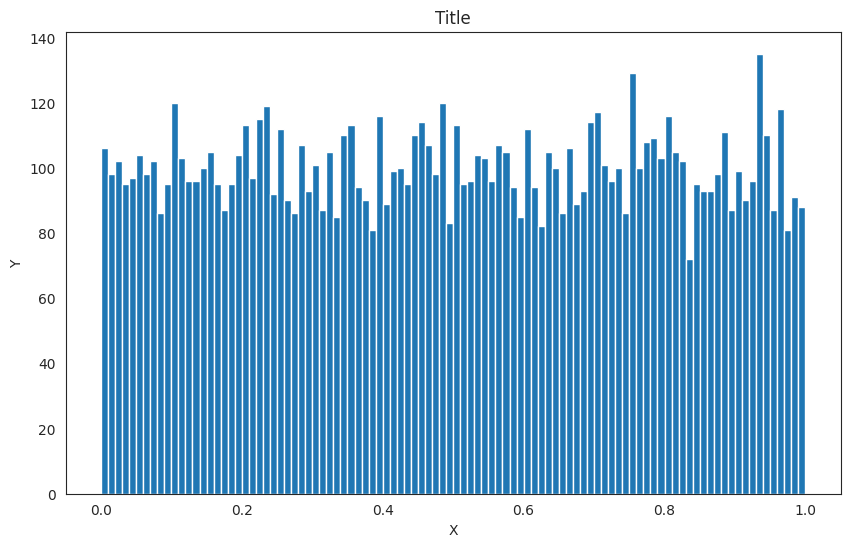

In [4]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(x, bins=100)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Title")
plt.show()


# Exponential distribution

https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.exponential.html

In [5]:
x = rng.exponential(scale=1, size=SIZE)
x, x.min(),x.mean(),x.max()

(array([0.20700721, 0.95645822, 0.73498941, ..., 0.01207577, 0.69830837,
        0.83430957]),
 2.8100517246821057e-05,
 0.9985676653159206,
 9.170211909715952)

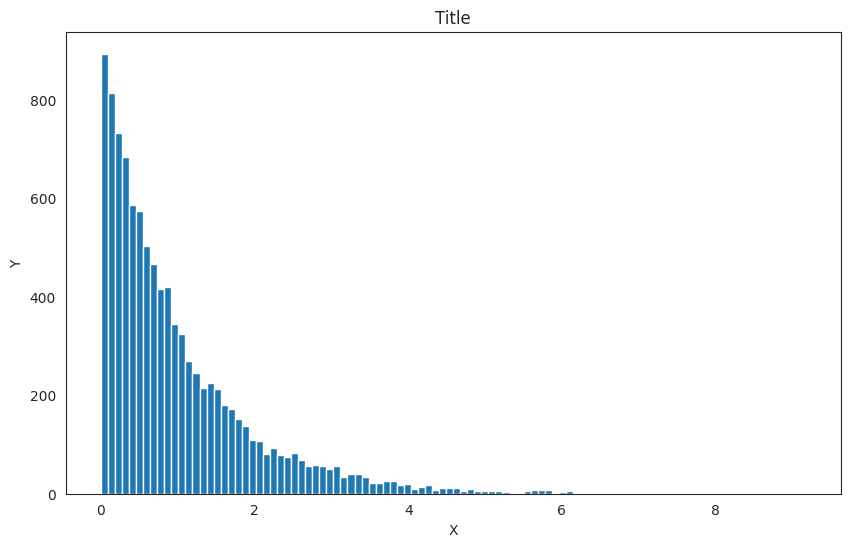

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(x, bins=100)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Title")
plt.show()


# Normal distribution

https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html

In [7]:
x = rng.normal(loc=0, scale=1, size=SIZE)
x, x.min(),x.mean(),x.max()

(array([-0.82061147, -0.16257442,  0.07785027, ..., -0.95039671,
         0.95221256, -0.50643409]),
 -3.581300842405585,
 0.0039666353700999425,
 5.272748399655818)

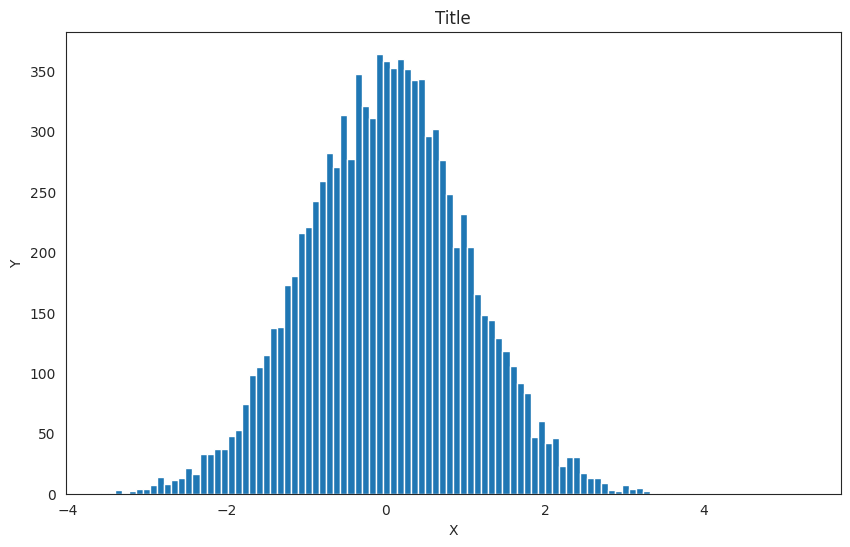

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(x, bins=100)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Title")
plt.show()


# Simulation Source - Sink

In [9]:
# create Simpy environment
env = simpy.Environment()

# create simple sink for packets
sink = PacketSink(env, "sink", debug=True)

# create a packet source
source = PacketSource(
    env,
    "source01",
    packet_interval=1, # interval between individual packets in simulation units
    packet_size=10 # packet size in Bytes
)

# link them together
source.destination = sink

# run the simulation
simulation_time = 20
env.run(until=simulation_time)

2023-09-04T15:31:20.300460+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     1). Arrival time   1.00. Processed: Packet(id=     0, size= 10.00, source=source01)
2023-09-04T15:31:20.300919+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     2). Arrival time   2.00. Processed: Packet(id=     1, size= 10.00, source=source01)
2023-09-04T15:31:20.301274+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     3). Arrival time   3.00. Processed: Packet(id=     2, size= 10.00, source=source01)
2023-09-04T15:31:20.301469+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     4). Arrival time   4.00. Processed: Packet(id=     3, size= 10.00, source=source01)
2023-09-04T15:31:20.301760+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     5). Arrival time   5.00. Processed: Packet(id=     4, size= 10.00, source=source01)
2023-09-04T15:31:20.301936+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     6). Arrival time   6.00. Processed: Packet(id=     5, size= 10.0

## Task
* Modify the simulation code above to have 2 packet sources with varying sizes and interarrival times.
* Using the built-in partial function, experiment with the use of statistical distributions for packet sizes and interarrivals.

# Simulation Source - Switch - Sink

In [10]:
env = simpy.Environment()

sink = PacketSink(env, "sink", debug=True)

switch = Switch(
    env,
    "switch01",
    num_ports=4, # how many ports does the switch have. IMPORTANT: port is a bi-partisan connection so it actually represents 2 physical ports on a real-world switch
    port_capacity=100, # queue lenght in Bytes
    port_transmission_rate=1000 # bits/s
) 

source = PacketSource(env, "source01", packet_interval=partial(rng.normal, 2,0.5), packet_size=partial(rng.exponential, 50))


source.destination = switch.ports[0]
switch.ports[0].destination = sink

simulation_time = 200
env.run(until=simulation_time)

2023-09-04T15:31:20.315363+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     1). Arrival time   2.29. Processed: Packet(id=    19, size= 31.00, source=source01)
2023-09-04T15:31:20.315684+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     2). Arrival time   5.70. Processed: Packet(id=    21, size=  5.00, source=source01)
2023-09-04T15:31:20.315931+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     3). Arrival time   8.03. Processed: Packet(id=    22, size= 27.00, source=source01)
2023-09-04T15:31:20.316108+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     4). Arrival time   9.96. Processed: Packet(id=    23, size= 12.00, source=source01)
2023-09-04T15:31:20.316268+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     5). Arrival time  11.97. Processed: Packet(id=    24, size= 12.00, source=source01)
2023-09-04T15:31:20.316433+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     6). Arrival time  13.63. Processed: Packet(id=    25, size= 39.0

## How long were packets in the system? 

In [11]:
sink.delays, sink.arrivals, sink.interarrivals

([0.24799999999999978,
  0.040000000000000036,
  0.2159999999999993,
  0.09600000000000009,
  0.09600000000000009,
  0.3119999999999994,
  0.26399999999999935,
  0.007999999999999119,
  0.3440000000000012,
  0.3039999999999985,
  0.36799999999999855,
  0.7920000000000016,
  0.3440000000000012,
  0.4960000000000022,
  0.5039999999999978,
  0.02400000000000091,
  0.35999999999999943,
  0.14399999999999835,
  0.07200000000000273,
  0.14399999999999835,
  0.1599999999999966,
  0.7040000000000006,
  0.015999999999998238,
  0.06400000000000006,
  0.02400000000000091,
  0.2560000000000002,
  0.35999999999999943,
  0.1839999999999975,
  0.759999999999998,
  0.4240000000000066,
  0.5759999999999934,
  0.2079999999999984,
  0.23999999999999488,
  0.04000000000000625,
  0.055999999999997385,
  0.007999999999995566,
  0.22400000000000375,
  0.6640000000000015,
  0.12000000000000455,
  0.21599999999999397,
  0.3119999999999976,
  0.46399999999999864,
  0.14400000000000546,
  0.16800000000000637,
  

# Simulation Source - Switch - Sink with Network Tap

In [12]:
env = simpy.Environment()

sink = PacketSink(env, "sink", debug=True)

switch = Switch(
    env,
    "switch01",
    num_ports=4, # how many ports does the switch have. IMPORTANT: port is a bi-partisan connection so it actually represents 2 physical ports on a real-world switch
    port_capacity=100, # queue lenght in Bytes
    port_transmission_rate=1000 # bits/s
)
tap = NetworkTap(
    env,
    port=switch.ports[0] # port to be monitored
)

source = PacketSource(env, "source01", packet_interval=partial(rng.normal, 2,0.5), packet_size=partial(rng.exponential, 50))


source.destination = switch.ports[0]
switch.ports[0].destination = sink

simulation_time = 200
env.run(until=simulation_time)

2023-09-04T15:31:20.483049+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     1). Arrival time   2.83. Processed: Packet(id=   120, size= 99.00, source=source01)
2023-09-04T15:31:20.483390+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     2). Arrival time   3.99. Processed: Packet(id=   121, size= 10.00, source=source01)
2023-09-04T15:31:20.483768+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     3). Arrival time   5.78. Processed: Packet(id=   122, size= 18.00, source=source01)
2023-09-04T15:31:20.484103+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     4). Arrival time   8.50. Processed: Packet(id=   123, size= 15.00, source=source01)
2023-09-04T15:31:20.484415+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     5). Arrival time  10.95. Processed: Packet(id=   124, size= 38.00, source=source01)
2023-09-04T15:31:20.484648+0200 | INFO | PacketSink(sink_id=sink, logged_packets=     6). Arrival time  13.01. Processed: Packet(id=   125, size=  6.0

In [13]:
tap

NetworkTap(Last 10 packet counts=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], last 10 byte counts=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# M/M/1 System

# More complex systems of queues